In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install psycopg2-binary 

  Using cached psycopg2_binary-2.9.10-cp312-cp312-win_amd64.whl.metadata (5.0 kB)
Using cached psycopg2_binary-2.9.10-cp312-cp312-win_amd64.whl (1.2 MB)


In [3]:
from sqlalchemy import create_engine
import json

In [4]:
df = pd.read_csv('kindle_data-v2.csv')

In [5]:
df.head()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133102 entries, 0 to 133101
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   asin               133102 non-null  object 
 1   title              133102 non-null  object 
 2   author             132677 non-null  object 
 3   soldBy             123869 non-null  object 
 4   imgUrl             133102 non-null  object 
 5   productURL         133102 non-null  object 
 6   stars              133102 non-null  float64
 7   reviews            133102 non-null  int64  
 8   price              133102 non-null  float64
 9   isKindleUnlimited  133102 non-null  bool   
 10  category_id        133102 non-null  int64  
 11  isBestSeller       133102 non-null  bool   
 12  isEditorsPick      133102 non-null  bool   
 13  isGoodReadsChoice  133102 non-null  bool   
 14  publishedDate      84086 non-null   object 
 15  category_name      133102 non-null  object 
dtypes:

In [6]:
df.shape

(133102, 16)

In [7]:
df.describe()

,stars,reviews,price,category_id
count,133102.000000,133102.000000,133102.000000,133102.000000
mean,4.404090,887.375779,15.134127,16.287111
std,0.745646,5104.878777,22.254986,8.416924
min,0.000000,0.000000,0.000000,1.000000
25%,4.400000,0.000000,4.990000,9.000000
50%,4.500000,4.000000,9.990000,16.000000
75%,4.700000,365.000000,14.990000,23.000000
max,5.000000,618227.000000,682.000000,31.000000


In [8]:
df.duplicated().sum()

0

In [9]:
null_values = df.isnull().sum()
null_val = null_values[null_values > 1]

df_null = pd.DataFrame({
    'Column': null_val.index,
    'Null Percentage' : (null_val.values/len(df))*100
})
print(df_null)

          Column  Null Percentage
0         author         0.319304
1         soldBy         6.936785
2  publishedDate        36.825893


In [10]:
df['publishedDate'].fillna("Unkown",inplace = True)
df['soldBy'].fillna('Unkown',inplace = True)
df.dropna(subset = 'author',inplace = True)

C:\Users\Sivashankar\AppData\Local\Temp\ipykernel_2228\3975265343.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['publishedDate'].fillna("Unkown",inplace = True)
C:\Users\Sivashankar\AppData\Local\Temp\ipykernel_2228\3975265343.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

In [11]:
df['publishedDate'] = df['publishedDate'] .replace('Unkown',pd.NaT)
df['publishedDate'] = pd.to_datetime(df['publishedDate'],errors = 'coerce')

In [12]:
df.drop(columns = ['imgUrl','productURL'],inplace=True)

In [13]:
df['published_year'] = df['publishedDate'].dt.year
df['published_year'] = df['published_year'].fillna(0).astype(int)
df['published_month'] = df['publishedDate'].dt.month
df['published_month'] = df['published_month'].fillna(0).astype(int)

In [14]:
df['genre_rating'] = round(df.groupby('category_name')['stars'].transform('mean').astype(float), 2)

In [15]:
df.head()

,asin,title,author,soldBy,stars,reviews,price,isKindleUnlimited,category_id,isBestSeller,isEditorsPick,isGoodReadsChoice,publishedDate,category_name,published_year,published_month,genre_rating
0,B00TZE87S4,Adult Children of Emotionally Immature Parents...,Lindsay C. Gibson,Amazon.com Services LLC,4.8,0,9.99,False,6,True,False,False,2015-06-01,Parenting & Relationships,2015,6,4.45
1,B08WCKY8MB,"From Strength to Strength: Finding Success, Ha...",Arthur C. Brooks,Penguin Group (USA) LLC,4.4,0,16.99,False,6,False,False,False,2022-02-15,Parenting & Relationships,2022,2,4.45
2,B09KPS84CJ,Good Inside: A Guide to Becoming the Parent Yo...,Becky Kennedy,HarperCollins Publishers,4.8,0,16.99,False,6,False,True,False,2022-09-13,Parenting & Relationships,2022,9,4.45
3,B07S7QPG6J,Everything I Know About Love: A Memoir,Dolly Alderton,HarperCollins Publishers,4.2,0,9.95,True,6,False,True,False,2020-02-25,Parenting & Relationships,2020,2,4.45
4,B00N6PEQV0,The Seven Principles for Making Marriage Work:...,John Gottman,Random House LLC,4.7,0,13.99,False,6,False,False,False,2015-05-05,Parenting & Relationships,2015,5,4.45


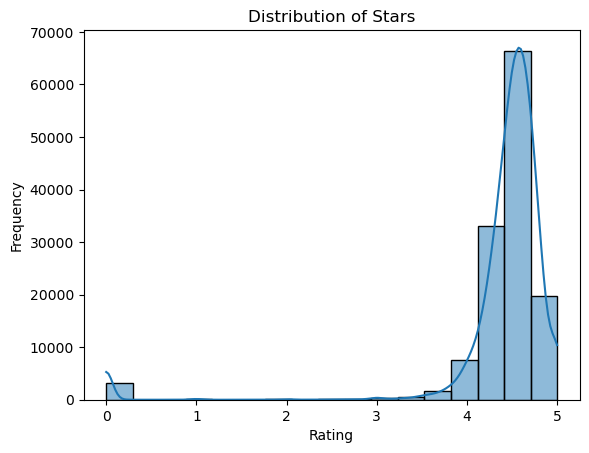

In [16]:
sns.histplot(x='stars',data=df,kde=True,bins=17)
plt.title('Distribution of Stars')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

C:\Users\Sivashankar\AppData\Local\Temp\ipykernel_2228\3385491865.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index,y=category_counts.values,palette='magma')


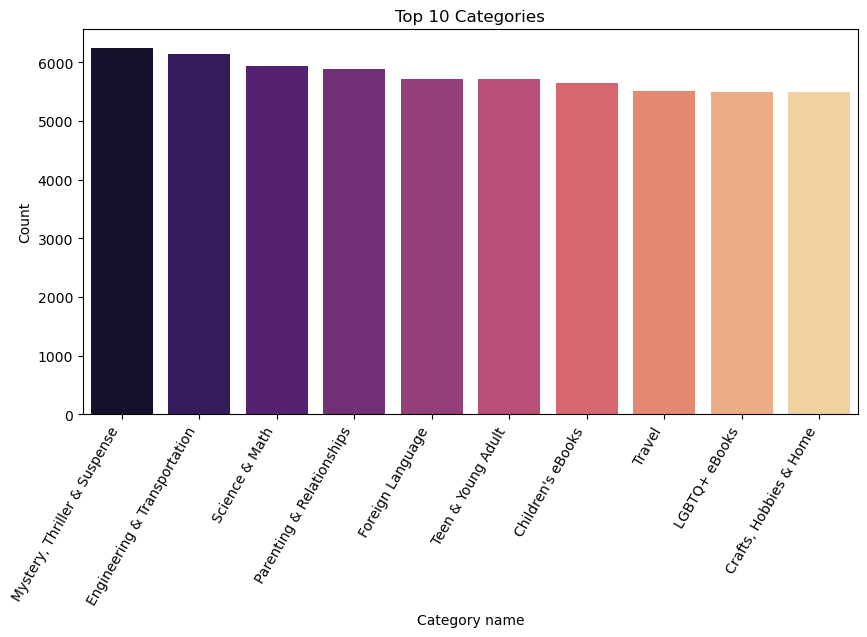

In [17]:
category_counts = df['category_name'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=category_counts.index,y=category_counts.values,palette='magma')
plt.title('Top 10 Categories')
plt.xlabel('Category name')
plt.ylabel('Count')
plt.xticks(rotation=60,ha='right')
plt.show()

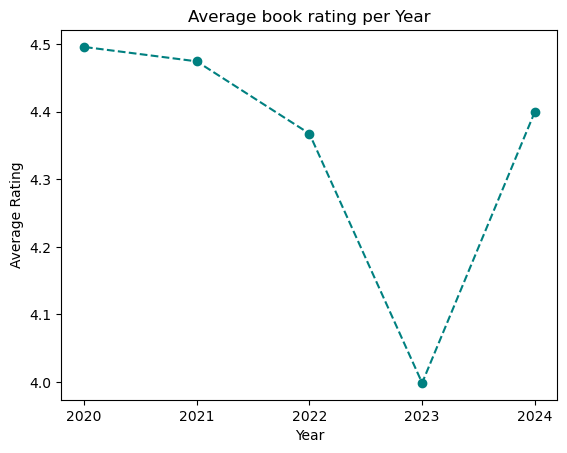

In [18]:
year_price = df.groupby('published_year')['stars'].mean().reset_index()
year_price = year_price.sort_values(by='published_year',ascending=False).head()
year_price['published_year'] = year_price['published_year'].round().astype(int)
plt.plot(year_price['published_year'],year_price['stars'],marker='o',linestyle='--',color='teal')
plt.title('Average book rating per Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.xticks(year_price['published_year'])
plt.show()

In [19]:
df.to_csv('amazon.csv', index=False) 
print("CSV file created: amazon.csv")


CSV file created: amazon.csv


In [20]:
host = 'localhost'
database_name = 'amazon_db'
username = 'postgres'
password = '***'
port_id = '5432'

data = pd.read_csv('amazon.csv')

engine = create_engine(f'postgresql+psycopg2://{username}:{password}@{host}:{port_id}/{database_name}')

try:
    data.to_sql('amazon_book', engine, if_exists='replace', index=False)
    print("Data successfully inserted")
except Exception as e:
    print(f"Error")



Data successfully inserted
